In [1]:
%%capture
!pip install tensorflow==2.17.0

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

from tensorflow import keras

2025-05-20 16:14:41.167838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 16:14:41.180701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 16:14:41.196214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 16:14:41.200840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 16:14:41.214866: I tensorflow/core/platform/cpu_feature_guar

In [4]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            img = np.array(img) / 255.0  # Normalize
            images.append(img)
            labels.append(label)

    return images, labels

In [5]:
positive_dir = "training_data/positive"
negative_dir = "training_data/negative"

pos_images, pos_labels = load_images_from_folder(positive_dir, 1)
neg_images, neg_labels = load_images_from_folder(negative_dir, 0)

# Combine data
images = np.array(pos_images + neg_images)
labels = np.array(pos_labels + neg_labels)

In [6]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(images, labels, test_size=0.2, random_state=0, stratify=labels)

num_folds = 5
epochs_multiple = 3
num_epochs = 300

num_epoch_batches = num_epochs // epochs_multiple
total_num_epochs = num_folds * num_epochs

In [7]:
def get_weighted_by_kernel(values, kernel = [16, 4, 1]):
    weighted_values = []
    for i in range(len(values)):
        lower_bound = max(0, i - (len(kernel) - 1))
        upper_bound = min(len(values) - 1, i + (len(kernel) - 1))
    
        sublist = values[lower_bound:upper_bound+1]
    
        weights = [(loss, kernel[abs(i - (idx + lower_bound))]) for idx, loss in enumerate(sublist)]
        weighted_values.append(sum([loss * weight for loss, weight in weights]) / sum([weight for _, weight in weights]))

    return weighted_values

135


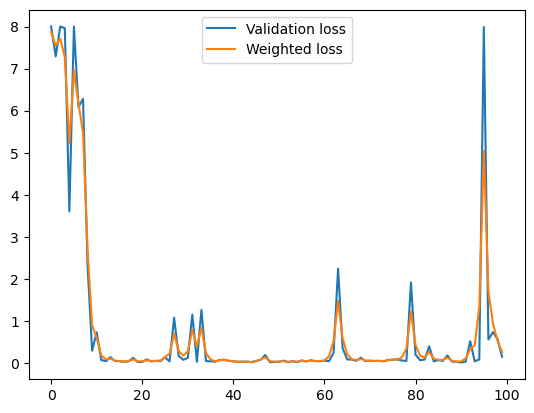

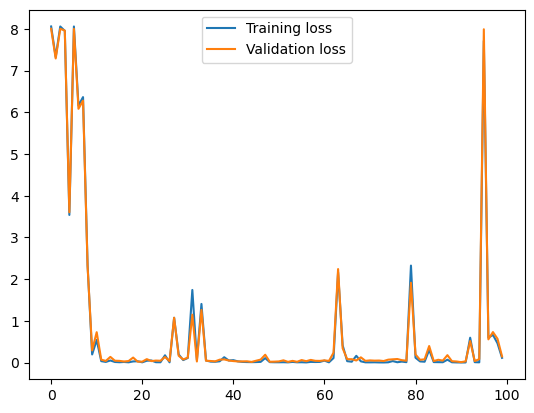

480


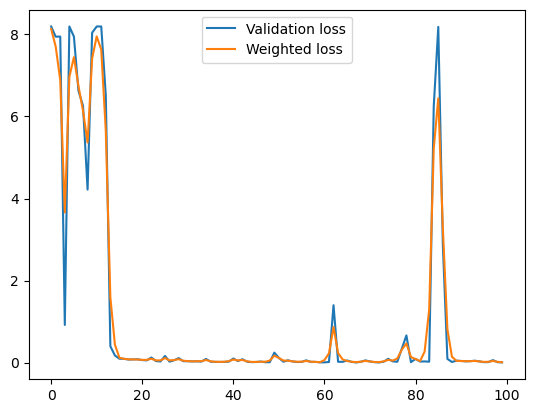

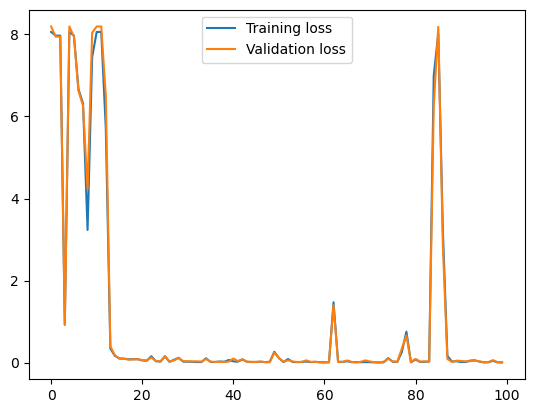

639


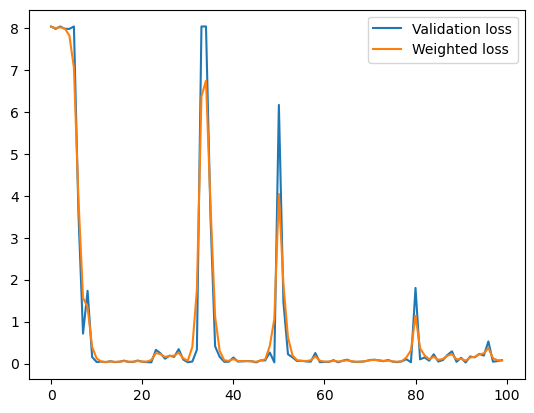

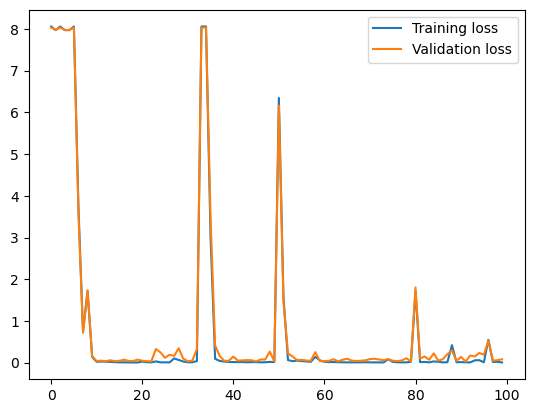

1155


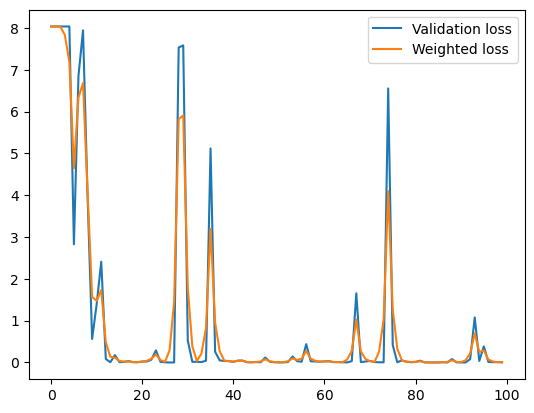

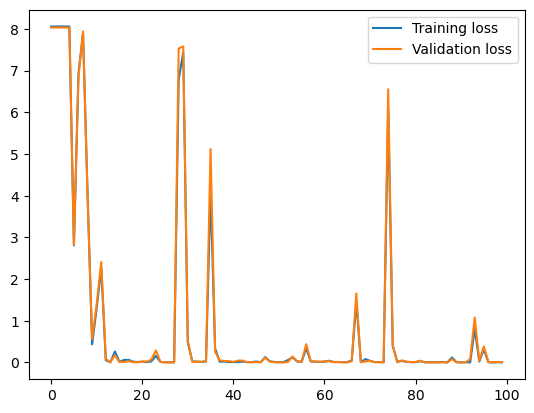

1296


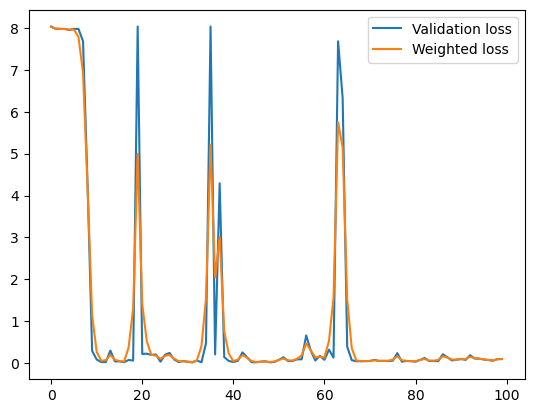

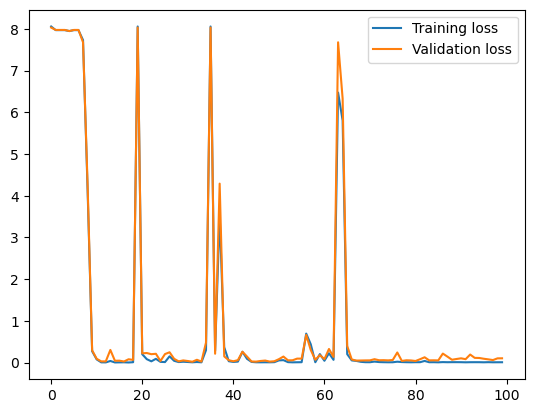

In [8]:
with open(f"models/loss_metrics_{total_num_epochs}_{total_num_epochs}.json", 'r') as f:
    loss_metrics = json.load(f)

models_ensemble = []
for i in range(num_folds):
    training_losses = [train_loss for train_loss, _ in loss_metrics[i*num_epoch_batches:(i+1)*num_epoch_batches]]
    validation_losses = [val_loss for _, val_loss in loss_metrics[i*num_epoch_batches:(i+1)*num_epoch_batches]]
    weighted_losses = get_weighted_by_kernel(validation_losses)

    best_epoch = (weighted_losses.index(min(weighted_losses)) + 1) * epochs_multiple + i * num_epochs
    models_ensemble.append(keras.models.load_model(f"models/ResNet_model_{best_epoch}.keras"))
    
    print(best_epoch)

    plt.plot(validation_losses, label="Validation loss")
    plt.plot(weighted_losses, label="Weighted loss")
    plt.legend()
    plt.show()
    
    plt.plot(training_losses, label="Training loss")
    plt.plot(validation_losses, label="Validation loss")
    plt.legend()
    plt.show()